#第5章 画像分類
##第5.2節 CNNによる手法～RetinaNetを実装してみよう

###モジュールのインポート

In [1]:
from tqdm import tqdm
from collections import deque
from typing import Callable, Sequence, Tuple, Union
import json
from pycocotools.cocoeval import COCOeval
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.utils import draw_bounding_boxes
from torchvision.ops import sigmoid_focal_loss, batched_nms
from torchvision.ops.misc import FrozenBatchNorm2d

import sys
sys.path.append('drive/MyDrive/5_object_detection/5_2_retinanet')

import util
import dataset
import transform as T

###バックボーンネットワークであるResNet18の残差ブロック

In [2]:
class BasicBlock(nn.Module):
    '''
    ResNet18における残差ブロック
    in_channels : 入力チャネル数
    out_channels: 出力チャネル数
    stride      : 畳み込み層のストライド
    '''
    def __init__(self, in_channels: int, out_channels: int,
                 stride: int=1):
        super().__init__()

        ''''' 残差接続 '''''
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = FrozenBatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = FrozenBatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        ''''''''''''''''''''

        # strideが1より大きいときにスキップ接続と残差接続の高さと幅を
        # 合わせるため、別途畳み込み演算を用意
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                FrozenBatchNorm2d(out_channels)
            )

    '''
    順伝播関数
    x: 入力, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        ''''' 残差接続 '''''
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        ''''''''''''''''''''

        if self.downsample is not None:
            x = self.downsample(x)

        # 残差写像と恒等写像の要素毎の和を計算
        out += x

        out = self.relu(out)

        return out

###バックボーンネットワークであるResNet18

In [3]:
class ResNet18(nn.Module):
    '''
    ResNet18モデル
    '''
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = FrozenBatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.max_pool = nn.MaxPool2d(kernel_size=3,
                                     stride=2, padding=1)

        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64),
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128),
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512),
        )

    '''
    順伝播関数
    x: 入力, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        c3 = self.layer2(x)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return c3, c4, c5

###特徴ピラミッドネットワーク

In [4]:
class FeaturePyramidNetwork(nn.Module):
    '''
    特徴ピラミッドネットワーク
    num_features: 出力特徴量のチャネル数
    '''
    def __init__(self, num_features: int=256):
        super().__init__()

        # 特徴ピラミッドネットワークから出力される階層レベル
        # バックボーンネットワークの最終層の特徴マップを第5階層とし、
        # 縮小方向に第6, 7階層の2つの特徴マップを、
        # 拡大方向に第3, 4階層の2つの特徴マップを生成
        self.levels = (3, 4, 5, 6, 7)

        ''' 縮小方向の特徴抽出 '''

        self.p6 = nn.Conv2d(512, num_features, kernel_size=3,
                            stride=2, padding=1)

        self.p7_relu = nn.ReLU(inplace=True)
        self.p7 = nn.Conv2d(num_features, num_features, kernel_size=3,
                            stride=2, padding=1)

        ''''''''''''''''''''''''''

        ''' 拡大方向の特徴抽出 '''

        self.p5_1 = nn.Conv2d(512, num_features, kernel_size=1)
        self.p5_2 = nn.Conv2d(num_features, num_features,
                              kernel_size=3, padding=1)

        self.p4_1 = nn.Conv2d(256, num_features, kernel_size=1)
        self.p4_2 = nn.Conv2d(num_features, num_features,
                              kernel_size=3, padding=1)

        self.p3_1 = nn.Conv2d(128, num_features, kernel_size=1)
        self.p3_2 = nn.Conv2d(num_features, num_features,
                              kernel_size=3, padding=1)

        ''''''''''''''''''''''''''

    '''
    順伝播関数
    c3: 特徴マップ, [バッチサイズ, チャネル数, 高さ, 幅]
    c4: 特徴マップ, [バッチサイズ, チャネル数, 高さ, 幅]
    c5: 特徴マップ, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, c3: torch.Tensor, c4: torch.Tensor,
                c5: torch.Tensor):
        ''' 縮小方向の特徴抽出 '''

        p6 = self.p6(c5)

        p7 = self.p7_relu(p6)
        p7 = self.p7(p7)

        ''''''''''''''''''''''''''

        ''' 拡大方向の特徴抽出 '''

        p5 = self.p5_1(c5)
        p5_up = F.interpolate(p5, scale_factor=2)
        p5 = self.p5_2(p5)

        p4 = self.p4_1(c4) + p5_up
        p4_up = F.interpolate(p4, scale_factor=2)
        p4 = self.p4_2(p4)

        p3 = self.p3_1(c3) + p4_up
        p3 = self.p3_2(p3)

        ''''''''''''''''''''''''''

        return p3, p4, p5, p6, p7

###検出ヘッドネットワーク

In [5]:
class DetectionHead(nn.Module):
    '''
    検出ヘッド(分類や矩形の回帰に使用)
    num_channels_per_anchor: 1アンカーに必要な出力チャネル数
    num_anchors            : アンカー数
    num_features           : 入力および中間特徴量のチャネル数
    '''
    def __init__(self, num_channels_per_anchor: int,
                 num_anchors: int=9, num_features: int=256):
        super().__init__()

        self.num_anchors = num_anchors

        # 特徴ピラミッドネットワークの特徴マップを分類や回帰専用の
        # 特徴マップに変換するための畳み込みブロック
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(nn.Conv2d(num_features, num_features,
                                    kernel_size=3, padding=1),
                          nn.ReLU(inplace=True))
            for _ in range(4)])

        # 予測結果をアンカーボックスの数だけ用意、例えば分類ヘッドの
        # 場合、チャネルをアンカーボックス数*物体クラス数に設定
        self.out_conv = nn.Conv2d(
            num_features, num_anchors * num_channels_per_anchor,
            kernel_size=3, padding=1)

    '''
    順伝播関数
    x: 特徴マップ, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        for i in range(4):
            x = self.conv_blocks[i](x)
        x = self.out_conv(x)

        bs, c, h, w = x.shape

        # 後処理に備えて予測結果を並び替え
        # permute関数により、
        # [バッチサイズ, チャネル数, 高さ, 幅]
        # -> [バッチサイズ, 高さ, 幅, チャネル数]
        x = x.permute(0, 2, 3, 1)
        # 第1軸に全画素の予測結果を並べる
        x = x.reshape(bs, w * h * self.num_anchors, -1)

        return x

###アンカーボックス生成器

In [6]:
class AnchorGenerator:
    '''
    検出の基準となるアンカーボックスを生成するクラス
    levels: 入力特徴マップの階層
    '''
    def __init__(self, levels: int):
        # 用意するアンカーボックスのアスペクト比(ハイパーパラメータ)
        ratios = torch.tensor([0.5, 1.0, 2.0])
        
        # 用意するアンカーボックスの基準となる大きさに
        # 対するスケール(ハイパーパラメータ)
        scales = torch.tensor([2 ** 0, 2 ** (1 / 3), 2 ** (2 / 3)])

        # 1つのアスペクト比に対して全スケールのアンカーボックスを
        # 用意するので、アンカーボックスの数のは
        # アスペクト比の数 * スケール数になる
        self.num_anchors = ratios.shape[0] * scales.shape[0]

        # 各階層の特徴マップでの1画素の移動量が入力画像での
        # 何画素の移動になるかを表す数値
        self.strides = [2 ** level for level in levels]

        self.anchors = []
        for level in levels:
            # 現階層における基準となる正方形のアンカーボックスの一辺の長さ
            # 深い階層のアンカーボックスには大きい物体の
            # 検出を担当させるため、基準の長さを長く設定
            base_length = 2 ** (level + 2)

            # アンカーボックスの1辺の長さをスケール
            scaled_lengths = base_length * scales
            # アンカーボックスが正方形の場合の面積を計算
            anchor_areas = scaled_lengths ** 2

            # アスペクト比(ratio)に応じて辺の長さを変更
            # width * height = width * (width * ratio) = areaより
            # width = (area / ratio) ** 0.5
            # unsqueezeとブロードキャストにより
            # アスペクト比の数 * スケール数の数のアンカーボックスの
            # 幅と高さを生成
            anchor_widths = (
                anchor_areas / ratios.unsqueeze(1)) ** 0.5
            anchor_heights = anchor_widths * ratios.unsqueeze(1)

            # アスペクト比の数 * スケール数の行列を平坦化
            anchor_widths = anchor_widths.flatten()
            anchor_heights = anchor_heights.flatten()

            # アンカーボックスの中心を原点としたときの
            # xmin, ymin, xmax, ymaxのオフセットをを計算
            anchor_xmin = -0.5 * anchor_widths
            anchor_ymin = -0.5 * anchor_heights
            anchor_xmax = 0.5 * anchor_widths
            anchor_ymax = 0.5 * anchor_heights

            level_anchors = torch.stack(
                (anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax),
                dim=1)

            self.anchors.append(level_anchors)

    '''
    アンカーボックス生成関数
    feature_sizes: 入力される複数の特徴マップそれぞれの大きさ
    '''
    # 関数内で勾配を計算する必要がないことを明示
    @torch.no_grad()
    def generate(self, feature_sizes: Sequence[torch.Size]):
        # 各階層の特徴マップの大きさを入力として、
        # 特徴マップの各画素におけるアンカーボックスを生成
        anchors = []
        for stride, level_anchors, feature_size in zip(
                self.strides, self.anchors, feature_sizes):
            # 現階層の特徴マップの大きさ
            height, width = feature_size

            # 入力画像の画素の移動量を表すstrideを使って
            # 特徴マップの画素の位置 -> 入力画像の画素の位置に変換
            # (画素の中心位置を計算するために0.5を加算)
            xs = (torch.arange(width) + 0.5) * stride
            ys = (torch.arange(height) + 0.5) * stride

            # x座標のリストととy座標のリストをを組み合わせて
            # グリッド上の座標を生成
            grid_x, grid_y = torch.meshgrid(xs, ys, indexing='xy')

            grid_x = grid_x.flatten()
            grid_y = grid_y.flatten()

            # 各画素の中心位置にアンカーボックスの
            # xmin, ymin, xmax, ymaxのオフセットを加算
            anchor_xmin = (
                grid_x.unsqueeze(1) + level_anchors[:, 0]).flatten()
            anchor_ymin = (
                grid_y.unsqueeze(1) + level_anchors[:, 1]).flatten()
            anchor_xmax = (
                grid_x.unsqueeze(1) + level_anchors[:, 2]).flatten()
            anchor_ymax = (
                grid_y.unsqueeze(1) + level_anchors[:, 3]).flatten()

            # 第1軸を追加してxmin, ymin, xmax, ymaxを連結
            level_anchors = torch.stack(
                (anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax),
                dim=1)

            anchors.append(level_anchors)

        # 全階層のアンカーボックスを連結
        anchors = torch.cat(anchors)

        return anchors

###RetinaNet

In [7]:
class RetinaNet(nn.Module):
    '''
    RetinaNetモデル(ResNet18バックボーン)
    num_classes: 物体クラス数
    '''
    def __init__(self, num_classes: int):
        super().__init__()

        self.backbone = ResNet18()

        self.fpn = FeaturePyramidNetwork()

        self.anchor_generator = AnchorGenerator(self.fpn.levels)

        # 分類および矩形ヘッド
        # 検出ヘッドは全ての特徴マップで共有
        self.class_head = DetectionHead(
            num_channels_per_anchor=num_classes,
            num_anchors=self.anchor_generator.num_anchors)
        
        # num_channels_per_anchor=4は
        # (x_diff, y_diff, w_diff, h_diff)を推論するため
        self.box_head = DetectionHead(
            num_channels_per_anchor=4,
            num_anchors=self.anchor_generator.num_anchors)

        self._reset_parameters()

    '''
    パラメータの初期化関数
    '''
    def _reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out',
                                        nonlinearity='relu')

        # 分類ヘッドの出力にシグモイドを適用して各クラスの確率を出力
        # 学習開始時の確率が0.01になるようにパラメータを初期化
        prior = torch.tensor(0.01)
        nn.init.zeros_(self.class_head.out_conv.weight)
        nn.init.constant_(self.class_head.out_conv.bias,
                          -((1.0 - prior) / prior).log())

        # 学習開始時のアンカーボックスの中心位置の移動が0、
        # 大きさが1倍となるように矩形ヘッドを初期化
        nn.init.zeros_(self.box_head.out_conv.weight)
        nn.init.zeros_(self.box_head.out_conv.bias)

    '''
    順伝播関数
    x: 入力画像, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        cs = self.backbone(x)
        ps = self.fpn(*cs)

        preds_class = torch.cat(list(map(self.class_head, ps)), dim=1)
        preds_box = torch.cat(list(map(self.box_head, ps)), dim=1)

        # 各特徴マップの高さと幅をリストに保持
        feature_sizes = [p.shape[2:] for p in ps]
        anchors = self.anchor_generator.generate(feature_sizes)
        anchors = anchors.to(x.device)

        return preds_class, preds_box, anchors

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.backbone.conv1.weight.device

###後処理を行う関数

In [8]:

'''
preds_class   : 検出矩形のクラス,
                [バッチサイズ, アンカーボックス数, 物体クラス数]
preds_box     : 検出矩形のアンカーボックスからの誤差,
                [バッチサイズ, アンカーボックス数,
                                4 (x_diff, y_diff, w_diff, h_diff)]
anchors       : アンカーボックス,
                [アンカーボックス数, 4 (xmin, ymin, xmax, ymax)]
targets       : ラベル
conf_threshold: 信頼度の閾値
nms_threshold : NMSのIoU閾値
'''
@torch.no_grad()
def post_process(preds_class: torch.Tensor, preds_box: torch.Tensor,
                 anchors: torch.Tensor, targets: dict,
                 conf_threshold: float=0.05,
                 nms_threshold: float=0.5):
    batch_size = preds_class.shape[0]

    anchors_xywh = util.convert_to_xywh(anchors)

    # 中心座標の予測をスケール不変にするため、
    # 予測値をアンカーボックスの大きさでスケールする
    preds_box[:, :, :2] = anchors_xywh[:, :2] + \
        preds_box[:, :, :2] * anchors_xywh[:, 2:]
    preds_box[:, :, 2:] = preds_box[:, :, 2:].exp() * \
        anchors_xywh[:, 2:]

    preds_box = util.convert_to_xyxy(preds_box)

    # 物体クラスの予測確率をsigmoid関数で計算
    # RetinaNetでは背景クラスは存在せず、
    # 背景を表す場合は全ての物体クラスの予測確率が低くなるように
    # 実装されている
    preds_class = preds_class.sigmoid()

    # forループで画像毎に処理を実施
    scores = []
    labels = []
    boxes = []
    for img_preds_class, img_preds_box, img_targets in zip(
            preds_class, preds_box, targets):
        # 検出矩形が画像内に収まるように座標をクリップ
        img_preds_box[:, ::2] = img_preds_box[:, ::2].clamp(
            min=0, max=img_targets['size'][0])
        img_preds_box[:, 1::2] = img_preds_box[:, 1::2].clamp(
            min=0, max=img_targets['size'][1])

        # 検出矩形は入力画像の大きさに合わせたものになっているので、
        # 元々の画像に合わせて検出矩形をスケール
        img_preds_box *= img_targets['orig_size'][0] / \
            img_targets['size'][0]

        # 物体クラスのスコアとクラスIDを取得
        img_preds_score, img_preds_label = img_preds_class.max(dim=1)

        # 信頼度が閾値より高い検出矩形のみを残す
        keep = img_preds_score > conf_threshold
        img_preds_score = img_preds_score[keep]
        img_preds_label = img_preds_label[keep]
        img_preds_box = img_preds_box[keep]

        # クラス毎にNMSを適用
        keep_indices = batched_nms(img_preds_box, img_preds_score,
                                   img_preds_label, nms_threshold)

        scores.append(img_preds_score[keep_indices])
        labels.append(img_preds_label[keep_indices])
        boxes.append(img_preds_box[keep_indices])

    return scores, labels, boxes

###損失関数を計算する関数

In [9]:
'''
preds_class        : 検出矩形のクラス,
                     [バッチサイズ, アンカーボックス数, 物体クラス数]
preds_box          : 検出矩形のアンカーボックスからの誤差,
                     [バッチサイズ, アンカーボックス数,
                                4 (x_diff, y_diff, w_diff, h_diff)]
anchors            : アンカーボックス,
                     [アンカーボックス数, 4 (xmin, ymin, xmax, ymax)]
targets            : ラベル
iou_lower_threshold: 検出矩形と正解矩形をマッチさせるか決める下の閾値
iou_upper_threshold: 検出矩形と正解矩形をマッチさせるか決める上の閾値
'''
def loss_func(preds_class: torch.Tensor, preds_box: torch.Tensor,
              anchors: torch.Tensor, targets: dict,
              iou_lower_threshold: float=0.4,
              iou_upper_threshold: float=0.5):
    anchors_xywh = util.convert_to_xywh(anchors)

    # 画像毎に目的関数を計算
    loss_class = preds_class.new_tensor(0)
    loss_box = preds_class.new_tensor(0)
    for img_preds_class, img_preds_box, img_targets in zip(
            preds_class, preds_box, targets):
        # 現在の画像に対する正解矩形がないとき
        if img_targets['classes'].shape[0] == 0:
            # 全ての物体クラスの確率が0となるように
            # (背景として分類されるように)ラベルを作成
            targets_class = torch.zeros_like(img_preds_class)
            loss_class += sigmoid_focal_loss(
                img_preds_class, targets_class, reduction='sum')

            continue

        # 各画素のアンカーボックスと正解矩形のIoUを計算し、
        # 各アンカーボックスに対して最大のIoUを持つ正解矩形を抽出
        ious = util.calc_iou(anchors, img_targets['boxes'])[0]
        ious_max, ious_argmax = ious.max(dim=1)

        # 分類のラベルを-1で初期化
        # IoUが下の閾値と上の閾値の間にあるアンカーボックスは
        # ラベルを-1として損失を計算しないようにする
        targets_class = torch.full_like(img_preds_class, -1)

        # アンカーボックスとマッチした正解矩形のIoUが下の閾値より
        # 小さい場合、全ての物体クラスの確率が0となるようラベルを用意
        targets_class[ious_max < iou_lower_threshold] = 0

        # アンカーボックスとマッチした正解矩形のIoUが上の閾値より
        # 大きい場合、陽性のアンカーボックスとして分類回帰の対象にする
        positive_masks = ious_max > iou_upper_threshold
        num_positive_anchors = positive_masks.sum()

        # 陽性のアンカーボックスについて、マッチした正解矩形が示す
        # 物体クラスの確率を1、それ以外を0として出力するように
        # ラベルに値を代入
        targets_class[positive_masks] = 0
        assigned_classes = img_targets['classes'][ious_argmax]
        targets_class[positive_masks,
                      assigned_classes[positive_masks]] = 1

        # IoUが下の閾値と上の閾値の間にあるアンカーボックスについては
        # 分類の損失を計算しない
        loss_class += ((targets_class != -1) * sigmoid_focal_loss(
            img_preds_class, targets_class)).sum() / \
            num_positive_anchors.clamp(min=1)

        # 陽性のアンカーボックスが一つも存在しないとき
        # 矩形の誤差の学習はしない
        if num_positive_anchors == 0:
            continue

        # 各アンカーボックスにマッチした正解矩形を抽出
        assigned_boxes = img_targets['boxes'][ious_argmax]
        assigned_boxes_xywh = util.convert_to_xywh(assigned_boxes)

        # アンカーボックスとマッチした正解矩形との誤差を計算し、
        # ラベルと作成
        targets_box = torch.zeros_like(img_preds_box)
        # 中心位置の誤差はアンカーボックスの大きさでスケール
        targets_box[:, :2] = (
            assigned_boxes_xywh[:, :2] - anchors_xywh[:, :2]) / \
            anchors_xywh[:, 2:]
        # 大きさはアンカーボックスに対するスケールのlogを予測
        targets_box[:, 2:] = (assigned_boxes_xywh[:, 2:] / \
                              anchors_xywh[:, 2:]).log()

        # L1誤差とL2誤差を組み合わせたsmooth L1誤差を使用
        loss_box += F.smooth_l1_loss(img_preds_box[positive_masks],
                                     targets_box[positive_masks],
                                     beta=1 / 9)

    batch_size = preds_class.shape[0]
    loss_class = loss_class / batch_size
    loss_box = loss_box / batch_size

    return loss_class, loss_box

###学習・評価におけるハイパーパラメータやオプションの設定

In [10]:
class ConfigTrainEval:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 画像があるディレクトリ
        self.img_directory = 'val2014'
        # アノテーションファイルのパス
        self.anno_file = 'drive/MyDrive/data/coco2014/' \
        'instances_val2014_small.json'
        # パラメータを保存するパス
        self.save_file = 'retinanet.pth'
        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.2
        # 学習エポック数
        self.num_epochs = 50
        # 学習率を減衰させるエポック
        self.lr_drop = 45
        # 検証を行うエポック間隔
        self.val_interval = 5
        # 学習率
        self.lr = 1e-5
        # 勾配のクリップ上限
        self.clip = 0.1
        # 移動平均で計算する損失と正確度の値の数
        self.moving_avg = 100
        # バッチサイズ
        self.batch_size = 8
        # データローダーに使うCPUプロセスの数
        self.num_workers = 2
        # 学習に使うデバイス
        self.device = 'cuda'

###学習・評価を行う関数

In [11]:
def train_eval():
    config = ConfigTrainEval()
    
    # データ拡張・整形クラスの設定
    min_sizes = (480, 512, 544, 576, 608)
    train_transforms = T.Compose((
        T.RandomHorizontalFlip(),
        T.RandomSelect(
            T.RandomResize(min_sizes, max_size=1024),
            T.Compose((
                T.RandomSizeCrop(scale=(0.8, 1.0),
                                 ratio=(0.75, 1.333)),
                T.RandomResize(min_sizes, max_size=1024),
            ))
        ),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
    ))
    test_transforms = T.Compose((
        # テストは短辺最大で実行
        T.RandomResize((min_sizes[-1],), max_size=1024),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
    ))

    # データセットの用意
    train_dataset = dataset.CocoDetection(
        img_directory=config.img_directory,
        anno_file=config.anno_file, transform=train_transforms)
    val_dataset = dataset.CocoDetection(
        img_directory=config.img_directory,
        anno_file=config.anno_file, transform=test_transforms)

    # Subset samplerの生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数: {len(train_set)}')
    print(f'検証セットのサンプル数: {len(val_set)}')

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler,
        collate_fn=collate_func)
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set,
        collate_fn=collate_func)

    # RetinaNetの生成
    model = RetinaNet(len(train_dataset.classes))
    # ResNet18をImageNetの学習済みモデルで初期化
    # 最後の線形層がないなどのモデルの改変を許容するため、strict=False
    model.backbone.load_state_dict(torch.hub.load_state_dict_from_url(
        'https://download.pytorch.org/models/resnet18-5c106cde.pth'),
                                   strict=False)

    # モデルを指定デバイスに転送
    model.to(config.device)

    # Optimizerの生成
    optimizer = optim.AdamW(model.parameters(), lr=config.lr)

    # 指定したエポックで学習率を1/10に減衰するスケジューラを生成
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[config.lr_drop], gamma=0.1)

    for epoch in range(config.num_epochs):
        model.train()

        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses_class = deque()
            losses_box = deque()
            losses = deque()
            for imgs, targets in pbar:
                imgs = imgs.to(model.get_device())
                targets = [{k: v.to(model.get_device())
                            for k, v in target.items()}
                           for target in targets]

                optimizer.zero_grad()

                preds_class, preds_box, anchors = model(imgs)

                loss_class, loss_box = loss_func(
                    preds_class, preds_box, anchors, targets)
                loss = loss_class + loss_box

                loss.backward()

                # 勾配全体のL2ノルムが上限を越えるとき上限値でクリップ
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), config.clip)

                optimizer.step()

                losses_class.append(loss_class.item())
                losses_box.append(loss_box.item())
                losses.append(loss.item())
                if len(losses) > config.moving_avg:
                    losses_class.popleft()
                    losses_box.popleft()
                    losses.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'loss_class': torch.Tensor(
                        losses_class).mean().item(),
                    'loss_box': torch.Tensor(
                        losses_box).mean().item()})

        # スケジューラでエポック数をカウント
        scheduler.step()

        # パラメータを保存
        torch.save(model.state_dict(), config.save_file)

        # 検証
        if (epoch + 1) % config.val_interval == 0:
            evaluate(val_loader, model, loss_func)

###サンプルからミニバッチを生成するcollate関数

In [12]:
'''
batch: CocoDetectionからサンプルした複数の画像とラベルをまとめたもの
'''
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, dict]]]):
    # ミニバッチの中の画像で最大の高さと幅を取得
    max_height = 0
    max_width = 0
    for img, _ in batch:
        height, width = img.shape[1:]
        max_height = max(max_height, height)
        max_width = max(max_width, width)

    # バックボーンネットワークで特徴マップの解像度を下げるときに
    # 切り捨てが起きないように入力の幅と高さを32の倍数にしておく
    # もし32の倍数でない場合、バックボーンネットワークの特徴マップと
    # 特徴ピラミッドネットワークのアップスケーリングでてきた特徴マップ
    # の大きさに不整合が生じ、加算できなくなる
    height = (max_height + 31) // 32 * 32
    width = (max_width + 31) // 32 * 32

    # 画像を一つにテンソルにまとめ、ラベルはリストに集約
    imgs = batch[0][0].new_zeros((len(batch), 3, height, width))
    targets = []
    for i, (img, target) in enumerate(batch):
        height, width = img.shape[1:]
        imgs[i, :, :height, :width] = img

        targets.append(target)

    return imgs, targets

###評価関数

In [13]:
'''
data_loader   : 評価に使うデータを読み込むデータローダ
model         : 評価対象のモデル
loss_func     : 目的関数
conf_threshold: 信頼度の閾値
nms_threshold : NMSのIoU閾値
'''
def evaluate(data_loader: DataLoader, model: nn.Module,
             loss_func: Callable, conf_threshold: float=0.05,
             nms_threshold: float=0.5):
    model.eval()

    losses_class = []
    losses_box = []
    losses = []
    preds = []
    img_ids = []
    for imgs, targets in tqdm(data_loader, desc='[Validation]'):
        with  torch.no_grad():
            imgs = imgs.to(model.get_device())
            targets = [{k: v.to(model.get_device())
                        for k, v in target.items()}
                       for target in targets]

            preds_class, preds_box, anchors = model(imgs)

            loss_class, loss_box = loss_func(
                preds_class, preds_box, anchors, targets)
            loss = loss_class + loss_box

            losses_class.append(loss_class)
            losses_box.append(loss_box)
            losses.append(loss)

            # 後処理により最終的な検出矩形を取得
            scores, labels, boxes = post_process(
                preds_class, preds_box, anchors, targets,
                conf_threshold=conf_threshold,
                nms_threshold=nms_threshold)

            for img_scores, img_labels, img_boxes, img_targets in zip(
                    scores, labels, boxes, targets):
                img_ids.append(img_targets['image_id'].item())

                # 評価のためにCOCOの元々の矩形表現である
                # xmin, ymin, width, heightに変換
                img_boxes[:, 2:] -= img_boxes[:, :2]

                for score, label, box in zip(
                        img_scores, img_labels, img_boxes):
                    # COCO評価用のデータの保存
                    preds.append({
                        'image_id': img_targets['image_id'].item(),
                        'category_id': \
                        data_loader.dataset.to_coco_label(
                            label.item()),
                        'score': score.item(),
                        'bbox': box.to('cpu').numpy().tolist()
                    })

    loss_class = torch.stack(losses_class).mean().item()
    loss_box = torch.stack(losses_box).mean().item()
    loss = torch.stack(losses).mean().item()
    print(f'Validation loss = {loss:.3f},'
          f'class loss = {loss_class:.3f}, '
          f'box loss = {loss_box:.3f} ')

    if len(preds) == 0:
        print('Nothing detected, skip evaluation.')

        return

    # COCOevalクラスを使って評価するには検出結果を
    # jsonファイルに出力する必要があるため、jsonファイルに一時保存
    with open('tmp.json', 'w') as f:
        json.dump(preds, f)

    # 一時保存した検出結果をCOCOクラスを使って読み込み
    coco_results = data_loader.dataset.coco.loadRes('tmp.json')

    # COCOevalクラスを使って評価
    coco_eval = COCOeval(
        data_loader.dataset.coco, coco_results, 'bbox')
    coco_eval.params.imgIds = img_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

###学習データの解凍

In [14]:
!unzip drive/MyDrive/data/coco2014/val2014.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: v

###学習・評価の実行

In [15]:
train_eval()

loading annotations into memory...
Done (t=1.76s)
creating index...
index created!
loading annotations into memory...
Done (t=1.29s)
creating index...
index created!
学習セットのサンプル数: 8000
検証セットのサンプル数: 2000


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[Validation]: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


Validation loss = 0.366,class loss = 0.307, box loss = 0.059 
Loading and preparing results...
DONE (t=2.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.22s).
Accumulating evaluation results...
DONE (t=1.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Aver

[Validation]: 100%|██████████| 250/250 [00:48<00:00,  5.21it/s]


Validation loss = 0.342,class loss = 0.289, box loss = 0.053 
Loading and preparing results...
DONE (t=2.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.38s).
Accumulating evaluation results...
DONE (t=1.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Aver

[Validation]: 100%|██████████| 250/250 [00:47<00:00,  5.24it/s]


Validation loss = 0.360,class loss = 0.310, box loss = 0.050 
Loading and preparing results...
DONE (t=1.78s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.83s).
Accumulating evaluation results...
DONE (t=2.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Aver

[Validation]: 100%|██████████| 250/250 [00:47<00:00,  5.28it/s]


Validation loss = 0.378,class loss = 0.330, box loss = 0.049 
Loading and preparing results...
DONE (t=2.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.12s).
Accumulating evaluation results...
DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.271
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Aver

[Validation]: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s]


Validation loss = 0.375,class loss = 0.327, box loss = 0.048 
Loading and preparing results...
DONE (t=1.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.40s).
Accumulating evaluation results...
DONE (t=1.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Aver

[Validation]: 100%|██████████| 250/250 [00:46<00:00,  5.40it/s]


Validation loss = 0.388,class loss = 0.341, box loss = 0.047 
Loading and preparing results...
DONE (t=1.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.37s).
Accumulating evaluation results...
DONE (t=1.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Aver

[Validation]: 100%|██████████| 250/250 [00:42<00:00,  5.94it/s]


Validation loss = 0.382,class loss = 0.335, box loss = 0.046 
Loading and preparing results...
DONE (t=1.70s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.40s).
Accumulating evaluation results...
DONE (t=1.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Aver

[Validation]: 100%|██████████| 250/250 [00:40<00:00,  6.13it/s]


Validation loss = 0.377,class loss = 0.331, box loss = 0.046 
Loading and preparing results...
DONE (t=1.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.13s).
Accumulating evaluation results...
DONE (t=1.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Aver

[Validation]: 100%|██████████| 250/250 [00:40<00:00,  6.19it/s]


Validation loss = 0.443,class loss = 0.396, box loss = 0.047 
Loading and preparing results...
DONE (t=1.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.75s).
Accumulating evaluation results...
DONE (t=1.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Aver

[Validation]: 100%|██████████| 250/250 [00:39<00:00,  6.28it/s]


Validation loss = 0.423,class loss = 0.377, box loss = 0.045 
Loading and preparing results...
DONE (t=1.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.12s).
Accumulating evaluation results...
DONE (t=1.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Aver

###デモおけるハイパーパラメータやオプションの設定

In [25]:
class ConfigDemo:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        # 画像があるディレクトリ
        self.img_directory = 'drive/MyDrive/data/' \
        'object_detection'
        # 学習済みパラメータのパス
        self.load_file = 'retinanet.pth'
        # 検出対象の物体クラス
        self.classes = ['person', 'car']
        # デモに使うデバイス
        self.device = 'cuda'
        # 検出における信頼度の閾値
        self.conf_threshold = 0.6
        # 検出におけるNMSのIoU閾値
        self.nms_threshold = 0.5

###デモを行う関数

In [26]:
def demo():
    config = ConfigDemo()
    
    transforms = T.Compose((
        T.RandomResize((608,), max_size=1024),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
    ))

    # 学習済みのモデルパラメータを読み込み
    model = RetinaNet(len(config.classes))
    model.load_state_dict(torch.load(config.load_file))
    model.to(config.device)
    model.eval()

    for img_path in Path(config.img_directory).iterdir():
        img_orig = Image.open(img_path)
        width, height = img_orig.size

        # データ整形を適用するためにダミーのラベルを作成
        target = {
            'classes': torch.zeros((0,), dtype=torch.int64),
            'boxes': torch.zeros((0, 4), dtype=torch.float32),
            'size': torch.tensor((width, height), dtype=torch.int64),
            'orig_size': torch.tensor(
                (width, height), dtype=torch.int64),
        }

        # データ整形
        img, target = transforms(img_orig, target)
        imgs, targets = collate_func([(img, target)])

        with  torch.no_grad():
            imgs = imgs.to(model.get_device())
            targets = [{k: v.to(model.get_device())
                        for k, v in target.items()}
                       for target in targets]

            preds_class, preds_box, anchors = model(imgs)

            scores, labels, boxes = post_process(
                preds_class, preds_box, anchors, targets,
                conf_threshold=config.conf_threshold,
                nms_threshold=config.nms_threshold)

            # 描画用の画像を用意
            img = torch.tensor(np.asarray(img_orig))
            img = img.permute(2, 0, 1)

            # クラスIDをクラス名に変換
            labels = [config.classes[label] for label in labels[0]]

            # 矩形を描画
            img = draw_bounding_boxes(
                img, boxes[0], labels, colors='red',
                font='LiberationSans-Regular.ttf',
                font_size=42, width=4)
            img = img.permute(1, 2, 0)
            img = img.to('cpu').numpy()

            plt.imshow(img)
            plt.show()

###デモの実行

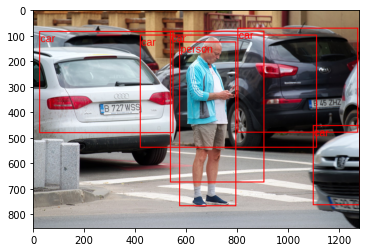

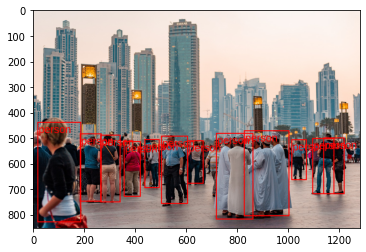

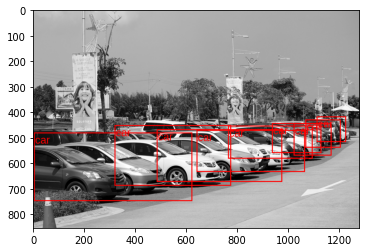

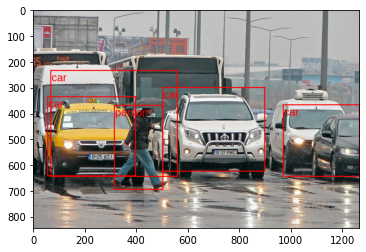

In [27]:
demo()